Regression model slope:     -4160169162.0
Regression model intercept: 8583953554589.3


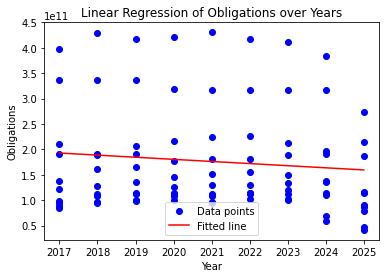

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

data = pd.read_csv('product.csv')

# change dollar to int
data['Obligations'] = data['Obligations'].replace({'US\$': '', ',': ''}, regex=True).astype(float)

X = data['Year'].values.reshape(-1, 1)  
y = data['Obligations'].values       

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

print("Regression model slope:    ", round(slope, 2))
print("Regression model intercept:", round(intercept, 2))

#plot
plt.scatter(X, y, color='blue', label='Data points')

xfit = np.array([X.min(), X.max()]).reshape(-1, 1)
yfit = model.predict(xfit)

plt.plot(xfit, yfit, color='red', label='Fitted line')
plt.xlabel('Year')
plt.ylabel('Obligations')
plt.title('Linear Regression of Obligations over Years')
plt.legend()
plt.show()

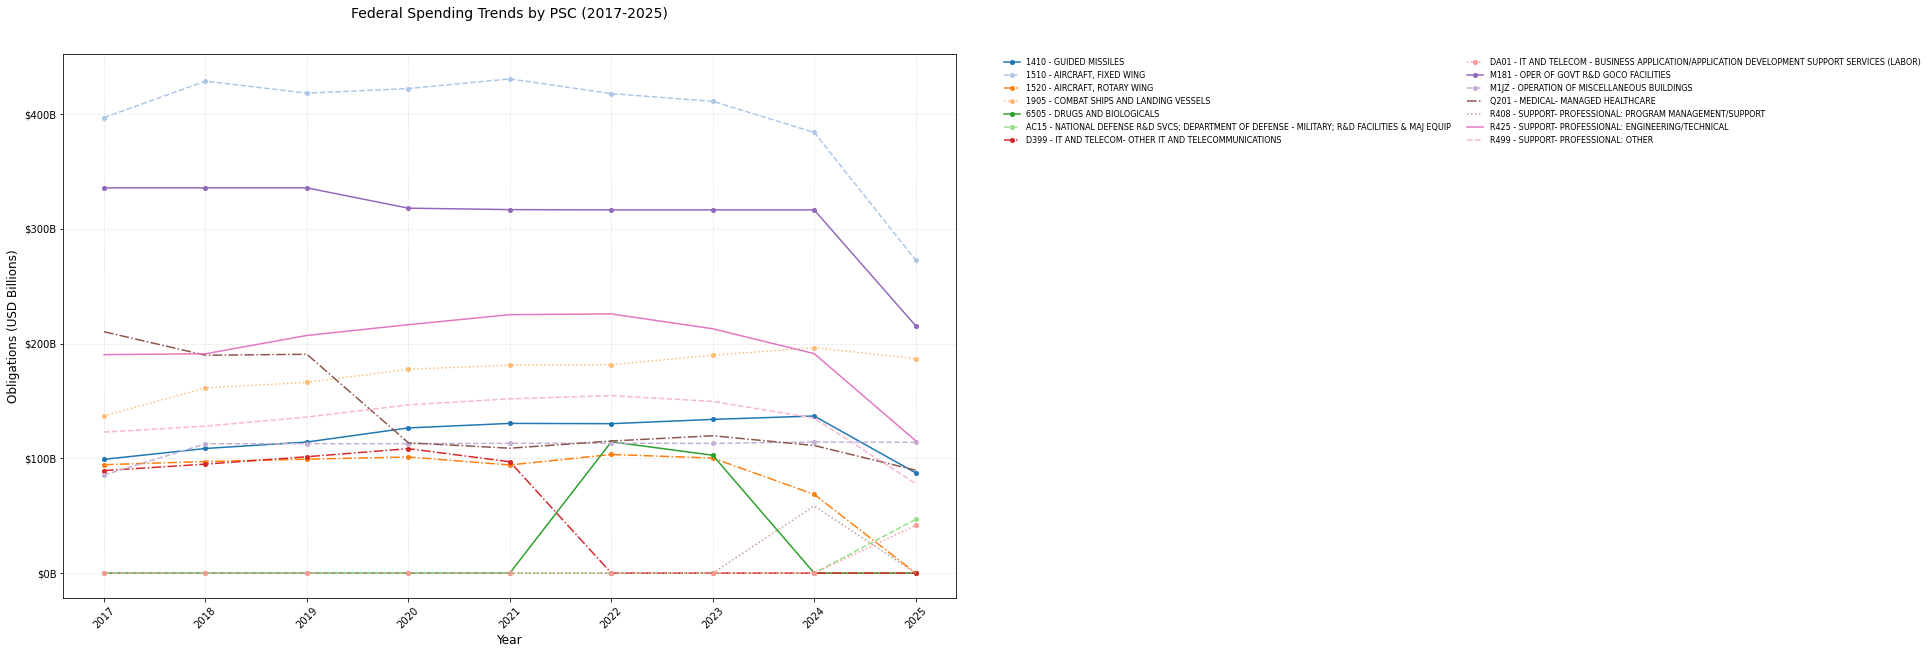

In [35]:
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('product.csv')
df['Obligations'] = df['Obligations'].replace({'US\$': '', ',': ''}, regex=True).astype(float)

# merge csv
pivot_df = df.pivot_table(
    index='Year',
    columns='Product and Service Code (PSC)',
    values='Obligations',
    aggfunc='sum'
).fillna(0)  

plt.figure(figsize=(16, 10))
ax = plt.gca()

colors = plt.cm.tab20(np.arange(len(pivot_df.columns)))
line_styles = ['-', '--', '-.', ':'] 

#loop to plot
for idx, psc in enumerate(pivot_df.columns):
    line_style = line_styles[idx % len(line_styles)]
    color = colors[idx % len(colors)]


    ax.plot(pivot_df.index,pivot_df[psc]/1e9,  # change unit
        label=psc,linestyle=line_style,color=color,linewidth=1.5,
        marker='o' if idx < 10 else None, 
        markersize=4)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}B'))
plt.xticks(pivot_df.index, rotation=45)

plt.title('Federal Spending Trends by PSC (2017-2025)\n', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Obligations (USD Billions)', fontsize=12)

plt.grid(True, alpha=0.3, linestyle='--')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=8,
        ncol=2,
        frameon=False)

plt.show()

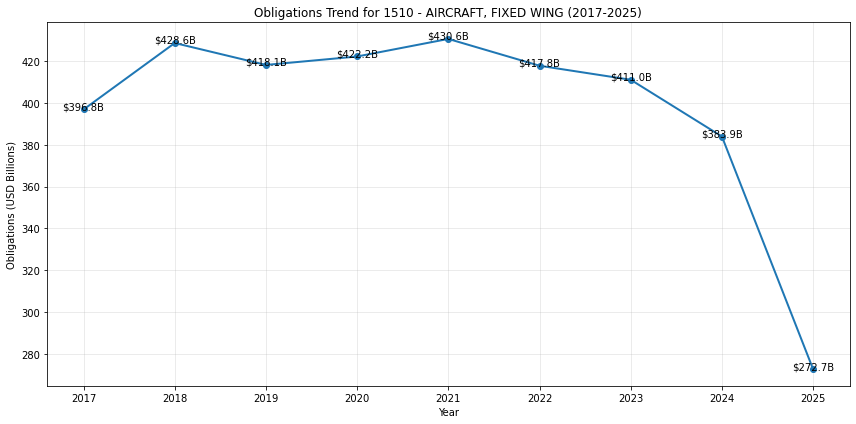

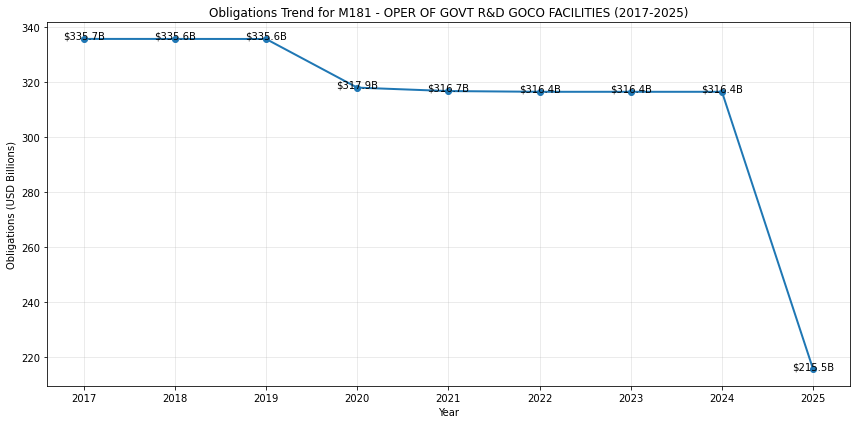

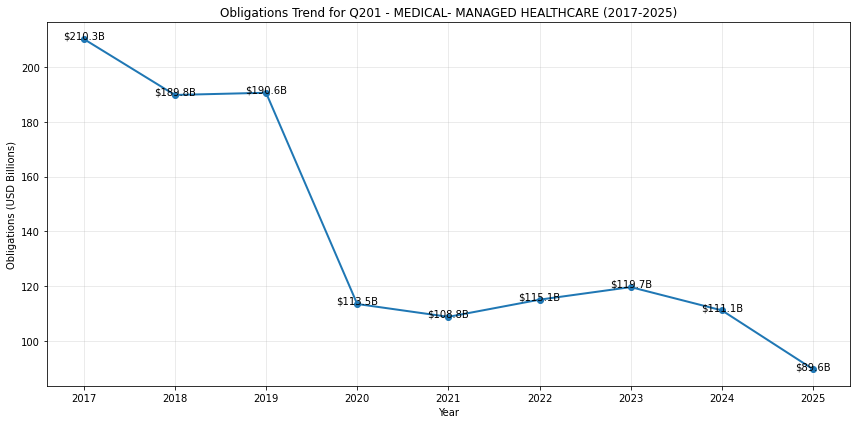

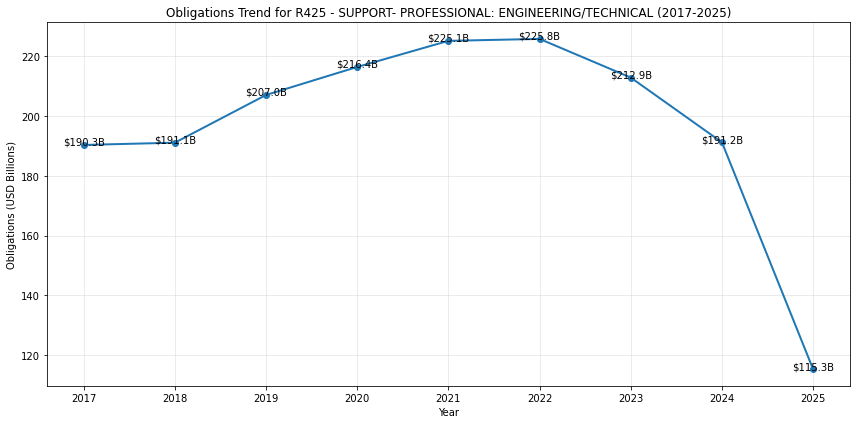

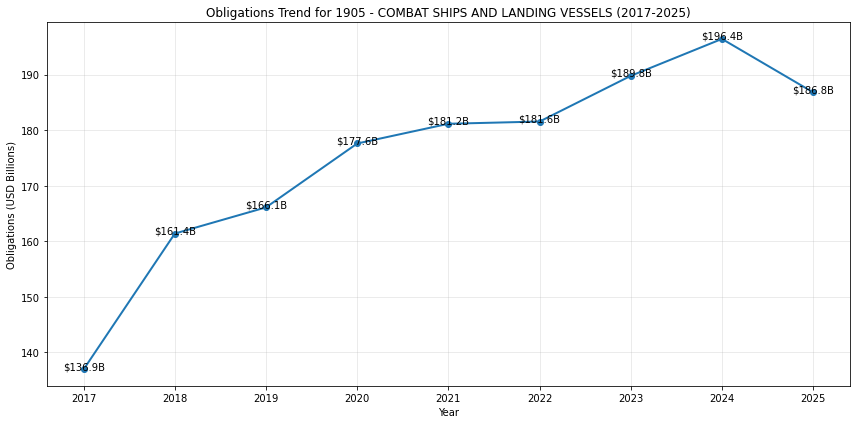

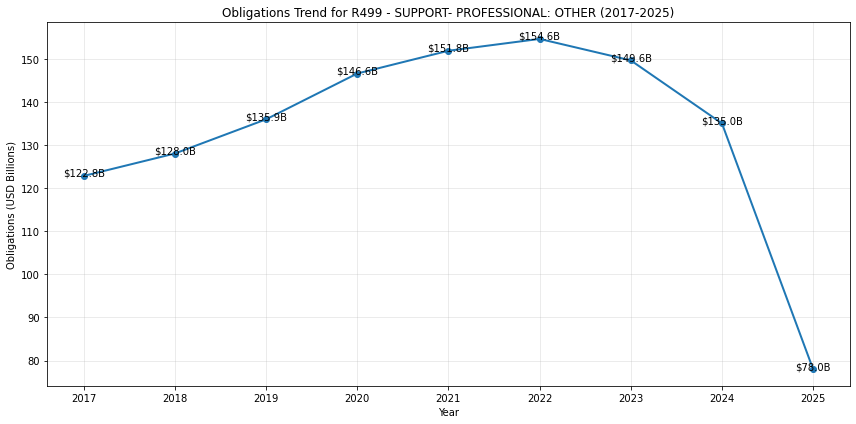

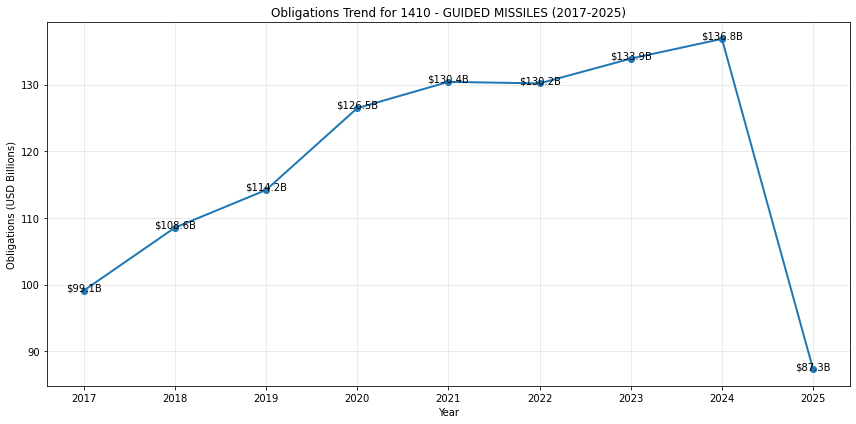

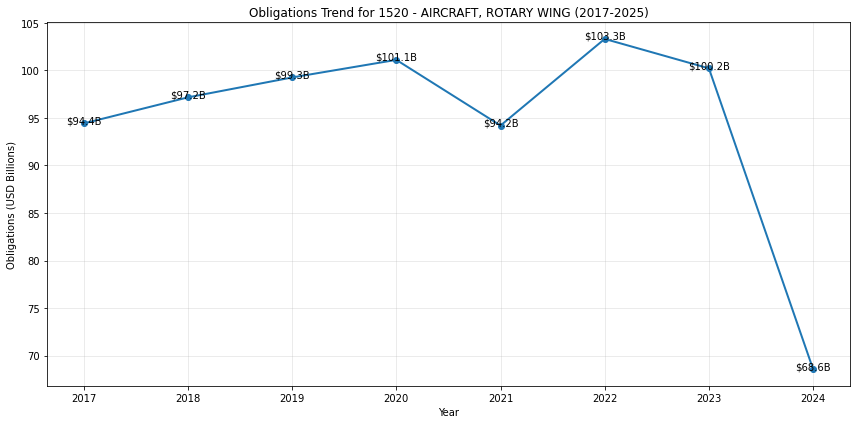

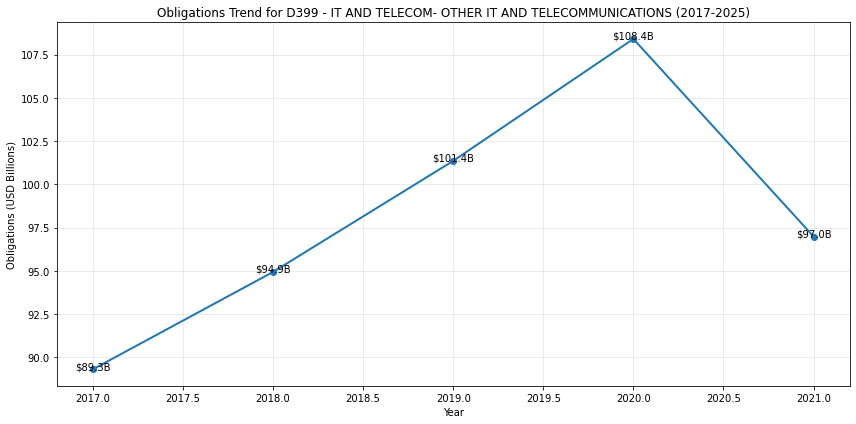

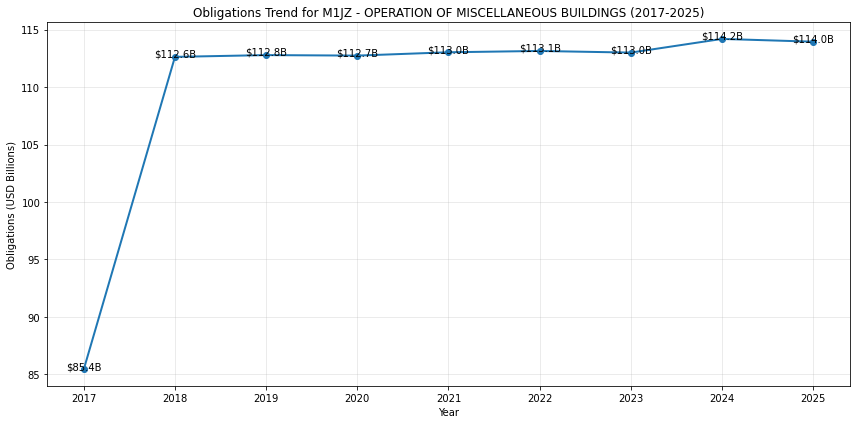

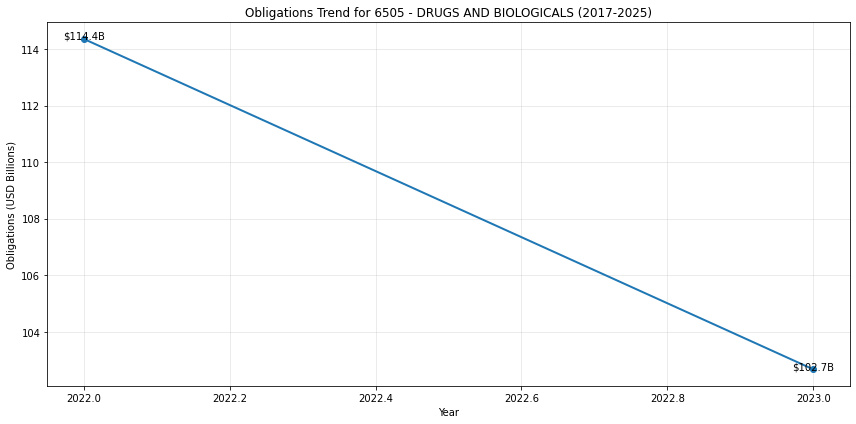

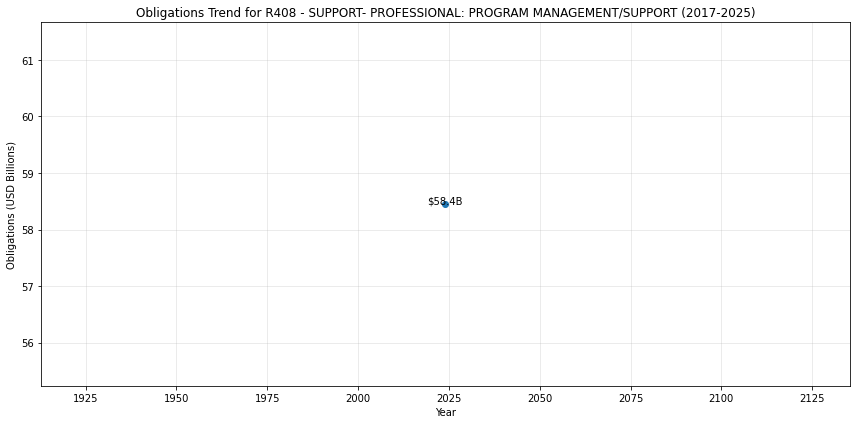

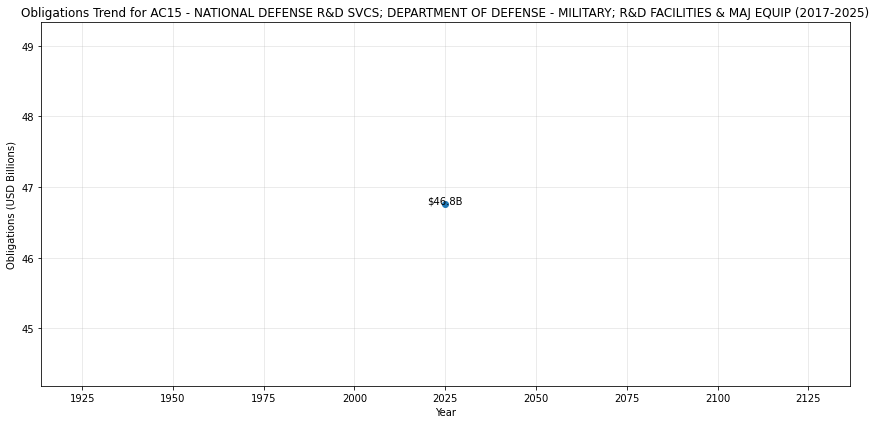

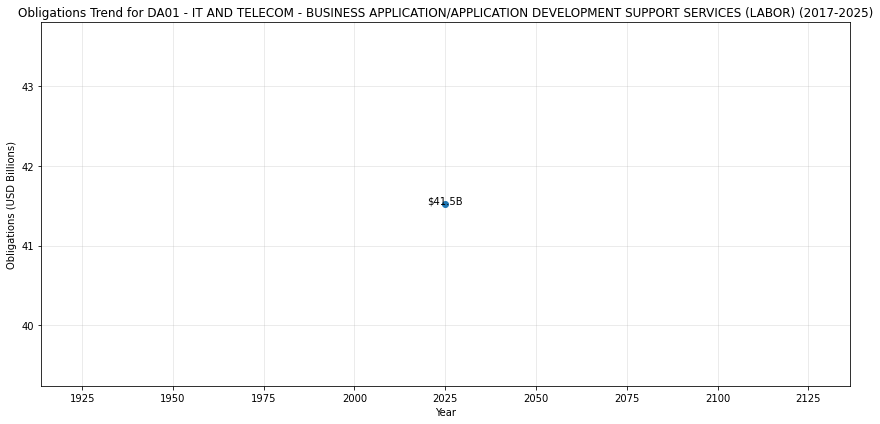

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('product.csv')

df['Obligations'] = df['Obligations'].replace({'US\$': '', ',': ''}, regex=True).astype(float)

all_psc = df['Product and Service Code (PSC)'].unique()

#loop 
for psc in all_psc:
    plt.figure(figsize=(12, 6))
    
    psc_data = df[df['Product and Service Code (PSC)'] == psc].sort_values('Year')
    
    if psc_data.empty:
        print(f"Skip : {psc}")
        plt.close()
        continue
    
    plt.plot(psc_data['Year'], psc_data['Obligations'] / 1e9,  
             marker='o',linestyle='-',linewidth=2)

    #plot every product
    plt.title(f'Obligations Trend for {psc} (2017-2025)')
    plt.xlabel('Year')
    plt.ylabel('Obligations (USD Billions)')
    plt.grid(True, alpha=0.3)

    for x, y in zip(psc_data['Year'], psc_data['Obligations'] / 1e9):
        plt.text(x, y, f'${y:.1f}B', ha='center')

    plt.tight_layout()
    plt.show()
    plt.close()

In [37]:
import pandas as pd

df = pd.read_csv('product.csv')
all_psc = df['Product and Service Code (PSC)'].unique()

keyword_dict = {}

for psc in all_psc:
    keyword = ' '.join(psc.split(' - ')[1].split()[:1]) 
    
    if keyword not in keyword_dict:
        keyword_dict[keyword] = [psc]
    else:
        keyword_dict[keyword].append(psc)

for keyword, psc_list in keyword_dict.items():
    if len(psc_list) > 1:  
        print(f"Keyword: {keyword}, Products: {psc_list}")

Keyword: AIRCRAFT,, Products: ['1510 - AIRCRAFT, FIXED WING', '1520 - AIRCRAFT, ROTARY WING']
Keyword: SUPPORT-, Products: ['R425 - SUPPORT- PROFESSIONAL: ENGINEERING/TECHNICAL', 'R499 - SUPPORT- PROFESSIONAL: OTHER', 'R408 - SUPPORT- PROFESSIONAL: PROGRAM MANAGEMENT/SUPPORT']
Keyword: IT, Products: ['D399 - IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS', 'DA01 - IT AND TELECOM - BUSINESS APPLICATION/APPLICATION DEVELOPMENT SUPPORT SERVICES (LABOR)']


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('product.csv')
df['Obligations'] = df['Obligations'].replace({'US\$': '', ',': ''}, regex=True).astype(float)

#Next_Obligations: will the product increase for next yr, 1, 0
df['Next_Obligations'] = df.groupby('Product and Service Code (PSC)')['Obligations'].shift(-1)
df['Increase'] = (df['Next_Obligations'] > df['Obligations']).astype(int)

#Feature enginnering: Year,Obligations
X = df[['Year', 'Obligations']].dropna()
y = df['Increase'].dropna()

X = X.loc[y.index]

#KNN
KNN_classifier = KNeighborsClassifier(n_neighbors=3)

cv_accuracy = cross_val_score(KNN_classifier, X, y, scoring='accuracy', cv=5)
y_pred = cross_val_predict(KNN_classifier, X, y, cv=5)

print('Accuracy (per fold)= ', cv_accuracy)
print('Accuracy (average)= ', round(cv_accuracy.mean(), 3), '(', round(cv_accuracy.std(), 3), ')')

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print('\nConfusion Matrix:')
print('=================')
print('TN=', tn, 'FP=', fp, 'FN=', fn, 'TP=', tp)
print('Recall/Sensitivity= ', round(tp/(tp + fn), 3))
print('Specificity= ', round(tn/(tn + fp), 3))
print('Precision= ', round(tp/(tp + fp), 3))

pca = decomposition.PCA(n_components=2)
pca.fit(X)
XX = pca.transform(X)

KNN1_classifier = KNeighborsClassifier(n_neighbors=3)
y_pred_pca = cross_val_predict(KNN1_classifier, XX, y, cv=5)

print('Accuracy (per fold, PCA)= ', cv_accuracy)
print('Accuracy (average, PCA)= ', round(cv_accuracy.mean(), 3), '(', round(cv_accuracy.std(), 3), ')')

tn, fp, fn, tp = confusion_matrix(y, y_pred_pca).ravel()
print('\nConfusion Matrix (PCA):')
print('=================')
print('TN=', tn, 'FP=', fp, 'FN=', fn, 'TP=', tp)
print('Recall/Sensitivity= ', round(tp/(tp + fn), 3))
print('Specificity= ', round(tn/(tn + fp), 3))
print('Precision= ', round(tp/(tp + fp), 3))

Accuracy (per fold)=  [0.61111111 0.66666667 0.38888889 0.5        0.55555556]
Accuracy (average)=  0.544 ( 0.096 )

Confusion Matrix:
TN= 26 FP= 23 FN= 18 TP= 23
Recall/Sensitivity=  0.561
Specificity=  0.531
Precision=  0.5
Accuracy (per fold, PCA)=  [0.61111111 0.66666667 0.38888889 0.5        0.55555556]
Accuracy (average, PCA)=  0.544 ( 0.096 )

Confusion Matrix (PCA):
TN= 26 FP= 23 FN= 18 TP= 23
Recall/Sensitivity=  0.561
Specificity=  0.531
Precision=  0.5


In [39]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

us_data = pd.read_csv("US data.csv")
us_data["Year"] = us_data["Year"].astype(int)

#fill null
us_data = us_data.fillna(us_data.mean(numeric_only=True))

product = pd.read_csv("product.csv")
def clean_currency(value):
    return float(value.replace("US$", "").replace(",", "").strip())

product["Obligations"] = product["Obligations"].apply(clean_currency)

product = product.sort_values(["Product", "Year"])
product["Next_Obligations"] = product.groupby("Product")["Obligations"].shift(-1)
product["Label"] = (product["Next_Obligations"] > product["Obligations"]).astype(int)

#split train and test data
train_data = product[product["Year"] < 2025].dropna(subset=["Next_Obligations"])
predict_data = product[product["Year"] == 2025]

merged = pd.merge(
    pd.concat([train_data, predict_data]),
    us_data[["Year", "GDP growth (annual %)", "Military spending (% of GDP)", "R&D expenditure (% of GDP)"]],
    on="Year",
    how="left"
)

#feature enginnering
def is_defense_related(product_name):
    defense_keywords = ["AIRCRAFT", "MISSILES", "SHIPS", "COMBAT"]
    return 1 if any(keyword in product_name.upper() for keyword in defense_keywords) else 0

merged["Is_Defense"] = merged["Product"].apply(is_defense_related)

#encode
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
product_encoded = encoder.fit_transform(merged[["Product"]])
product_encoded_df = pd.DataFrame(product_encoded, columns=encoder.get_feature_names_out(["Product"]))

merged = pd.concat([merged, product_encoded_df], axis=1)

features = merged[["GDP growth (annual %)", "Military spending (% of GDP)", "R&D expenditure (% of GDP)", "Is_Defense"] + list(product_encoded_df.columns)]
labels = merged["Label"]


X_train = features[~features.index.isin(predict_data.index)]
y_train = labels[~features.index.isin(predict_data.index)]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.2f}")

products_2025 = merged[merged["Year"] == 2025].copy()

prob = model.predict_proba(products_2025[features.columns])[:,1]
products_2025["%_of_Increase"] = prob

print("\n2025 Product predict result：")
print(products_2025[["Year", "Product", "%_of_Increase"]].sort_values("%_of_Increase", ascending=False))

Accuracy: 0.81
ROC-AUC: 0.78

2025 Product predict result：
    Year                                            Product  %_of_Increase
77  2025                   COMBAT SHIPS AND LANDING VESSELS       0.214177
78  2025                                    GUIDED MISSILES       0.201865
84  2025       SUPPORT- PROFESSIONAL: ENGINEERING/TECHNICAL       0.102936
83  2025               OPERATION OF MISCELLANEOUS BUILDINGS       0.099467
85  2025                       SUPPORT- PROFESSIONAL: OTHER       0.074721
81  2025  NATIONAL DEFENSE R&D SVCS; DEPARTMENT OF DEFEN...       0.067595
79  2025  IT AND TELECOM - BUSINESS APPLICATION/APPLICAT...       0.063773
76  2025                               AIRCRAFT, FIXED WING       0.059050
80  2025                        MEDICAL- MANAGED HEALTHCARE       0.050942
82  2025                   OPER OF GOVT R&D GOCO FACILITIES       0.020533
